### Загружаем выборку из файла:

In [1]:
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew
import numpy as np

data = open("Number_10.txt")

numbers = data.read().split()

for i in range(len(numbers)):
    num = numbers[i].split('e')
    numbers[i] = float(num[0])*10**int(num[1])

data.close()

numbers = np.array(numbers)
numbers.sort()
print(numbers)

[0.09759225 0.11209766 0.14273021 0.27925836 0.34366199 0.58075937
 0.58749193 0.60431646 0.60986089 0.6340657  0.63476597 0.77958676
 0.78652666 0.81611602 0.85902562 0.88644894 0.97275659 0.98511083
 0.98761797 1.0294928  1.0358564  1.062355   1.0656872  1.0806582
 1.1102641  1.1177285  1.1328376  1.2531638  1.2991789  1.3192923
 1.3490028  1.3528175  1.4204077  1.4327012  1.448533   1.4796039
 1.488337   1.5291781  1.6259641  1.6579628  1.7010535  1.7473526
 1.8007563  1.8249329  1.9124816  1.9497025  1.9661229  1.9848238
 2.0323415  2.1581683  2.2315143  2.3228809  2.5806805  2.6037424
 2.8133334  2.8898118  2.9480402  2.9998317  3.1581533  3.7435134 ]


## Выборочные характеристики:  выборочное среднее, выборочная дисперсия, выборочные коэффициенты асимметрии и эксцесса

In [2]:
print(f"Выборочное среднее: {round(np.mean(numbers), 8)}")
print(f"Выборочная дисперсия: {round(np.var(numbers, ddof=1), 8)}")
print(f"Выборочный коэффициент эксцесса: {round(kurtosis(numbers, bias=False), 8)}")
print(f"Выборочный коэффициент асимметрии: {round(skew(numbers, bias=False), 8)}")

Выборочное среднее: 1.43933418
Выборочная дисперсия: 0.66243578
Выборочный коэффициент эксцесса: 0.15865269
Выборочный коэффициент асимметрии: 0.67082743


## Строим эмпирическую функцию распределения и нормированную гистограмму

Интервалы: [0.0, 0.6666666666666666, 1.3333333333333333, 2.0, 2.6666666666666665, 3.333333333333333, 4.0]


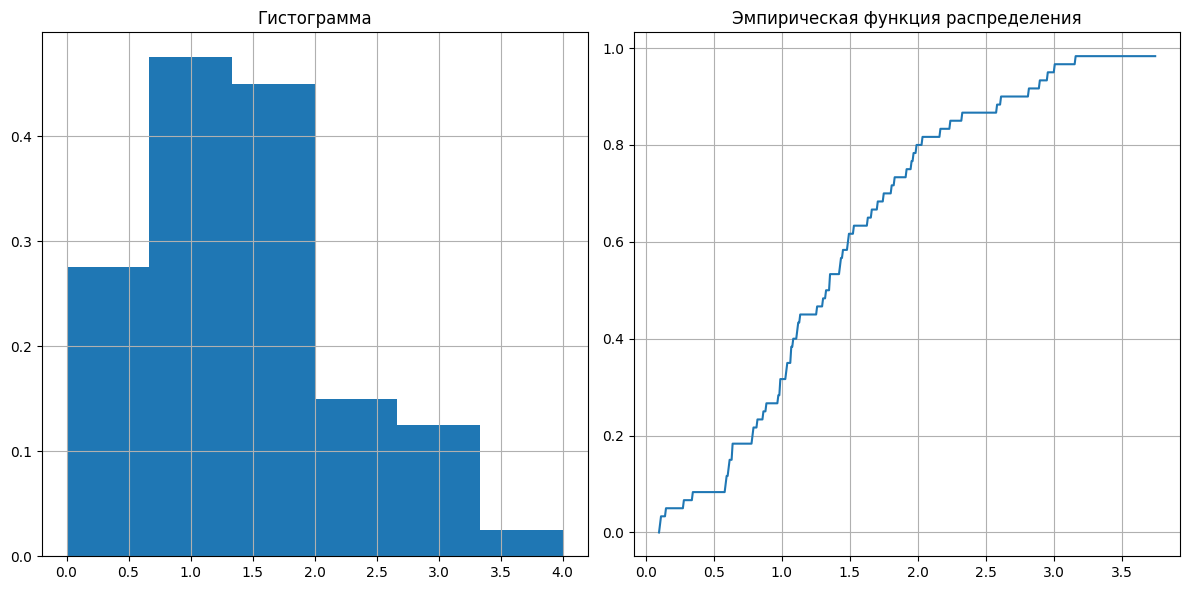

In [3]:
def emp_df(x: np.ndarray, sample: np.ndarray):
    f_points = []
    for i in x:
        y = (len(sample[sample < i])) / len(sample)
        f_points.append(y)
    return np.array(f_points)

a=min(numbers)
b=max(numbers)
grid = np.linspace(a, b, 500)
n = 7
bins = list(np.linspace(round(numbers[0]), round(numbers[-1]), n))
print(f"Интервалы: {bins}")

f, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(numbers, density=True, bins=bins)
ax[0].grid()
ax[0].set_title('Гистограмма')

ax[1].plot(grid, emp_df(grid, numbers))
ax[1].grid()
ax[1].set_title('Эмпирическая функция распределения')

f.tight_layout()

## По эмпирической функции распределения строим доверительные полосы для теоретической функции распределения с доверительными вероятностями  0.90 и 0.95:

Text(0.5, 1.0, 'Доверительные полосы')

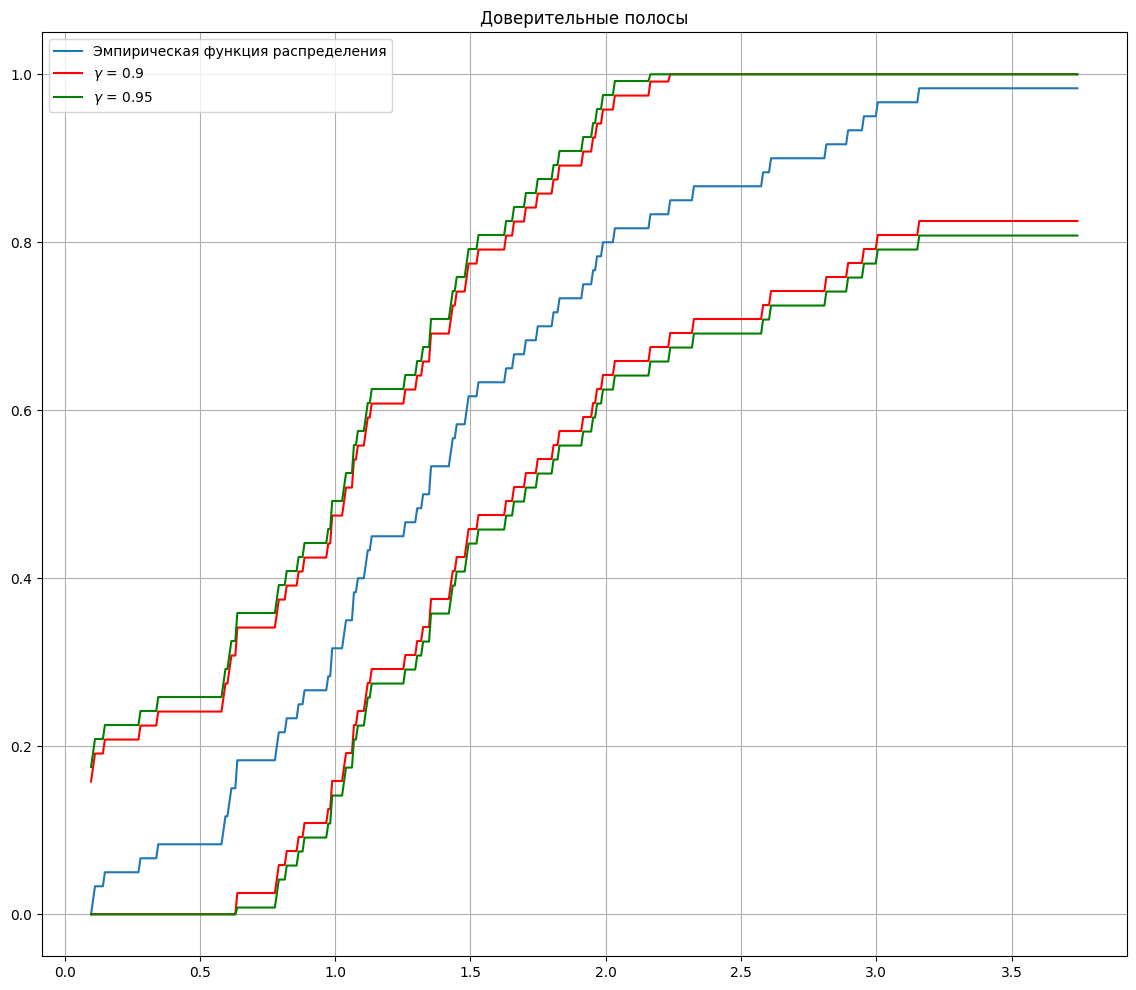

In [4]:
quantile = lambda gamma: np.sqrt((-1/2) * np.log((1 - gamma)/2))
L = lambda gamma: np.array([max(0, F - quantile(gamma) / np.sqrt(len(numbers))) for F in emp_df(grid, numbers)])
R = lambda gamma: np.array([min(1, F + quantile(gamma) / np.sqrt(len(numbers))) for F in emp_df(grid, numbers)])

f, ax = plt.subplots(1, 1, figsize=(14, 12))

ax.plot(grid, emp_df(grid, numbers), label='Эмпирическая функция распределения')

for _, gamma, clr in zip(range(2), [0.9, 0.95], ['r', 'g']):
    ax.plot(grid, L(gamma), color=clr, label=r"$\gamma$" + f" = {gamma}")
    ax.plot(grid, R(gamma), color=clr)

ax.grid()
ax.legend()
ax.set_title("Доверительные полосы")

## Проверка гипотезы о виде распределения на основе критерия хи-квадрат Фишера:

In [5]:
from scipy.stats import gamma, expon
from typing import Union

def theoretic_df_gamma(x: Union[float, np.ndarray], alpha: float, beta: float):
    return gamma.cdf(x, a=alpha, scale=beta)

def theoretic_df_expon(x: Union[float, np.ndarray], beta: float):
    return expon.cdf(x, scale=beta)

In [6]:
from scipy.optimize import minimize
import scipy.stats as st

def get_chi2(cdf2check: int, int_num: int, b_param: float, nums):
    borders = np.linspace(a, b, int_num+1)
    n = len(nums)
    p = [(cdf2check(borders[i+1], b_param) - cdf2check(borders[i], b_param)) for i in range(int_num)]
    m = [len([num for num in nums if borders[i] < num and num < borders[i+1]]) for i in range(int_num)]
    res = sum((mi - n * pi) ** 2 / (n * pi) for pi, mi in zip(p, m))
    return res

k = [3]
chi = [st.chi2.ppf(0.95, k[0] - 1 - 1)]
theta_exp = []
print("Экспоненциальное распределение\n")
for chi, order in zip(chi, k):
    chi2 = lambda x: get_chi2(theoretic_df_expon, order, b_param=x[0], nums=numbers)
    result = minimize(chi2, np.array([1.5]), method='nelder-mead', tol=1e-15)
    print(f"Вычисленное значение: {result['fun']},"
          f"\nОценка параметров: {result['x']}")
    theta_exp.append(result['x'])
    print(f"Chi: {chi}")
    if result['fun'] < chi:
        print(f"Результат проверки: Гипотеза принимается\n")
    else:
        print(f"Результат проверки: Отвергаем гипотезу\n")

Экспоненциальное распределение

Вычисленное значение: 5.454718066927879,
Оценка параметров: [1.80780542]
Chi: 3.841458820694124
Результат проверки: Отвергаем гипотезу



In [7]:
def get_chi2(cdf2check: int, int_num: int, a_param: float, b_param: float, nums):
    borders = np.linspace(a, b, int_num+1)
    n = len(nums)
    p = [(cdf2check(borders[i+1], a_param, b_param) - cdf2check(borders[i], a_param, b_param)) for i in range(int_num)]
    m = [len([num for num in nums if borders[i] < num and num < borders[i+1]]) for i in range(int_num)]
    res = sum((mi - n * pi) ** 2 / (n * pi) for pi, mi in zip(p, m))
    return res

k = [4,
     #4, 5
     ]
chi = [ st.chi2.ppf(0.95, k[0] - 2 - 1),
        #st.chi2.ppf(0.95, k[1] - 2 - 1),
        #st.chi2.ppf(0.95, k[2] - 2 - 1)
        ]
theta_gamma = []
print("Гамма-распределение\n")
for chi, order in zip(chi, k):
    chi2 = lambda x: get_chi2(theoretic_df_gamma, order, a_param=x[0], b_param=x[1], nums=numbers)
    result = minimize(chi2, np.array([2, 1.5]), method='nelder-mead', tol=1e-15)
    print(f"Вычисленное значение: {result['fun']},"
          f"\nОценка параметров: {result['x']}")
    theta_gamma.append(result['x'])
    print(f"Chi: {chi}")
    if result['fun'] < chi:
        print(f"Результат проверки: Гипотеза принимается\n")
    else:
        print(f"Результат проверки: Отвергаем гипотезу\n")

Гамма-распределение



Вычисленное значение: 0.27542978879580343,
Оценка параметров: [3.21027769 0.4755438 ]
Chi: 3.841458820694124
Результат проверки: Гипотеза принимается



### МП-оценки параметров распределения случайной величины. Построить с этими оценками гипотетические теоретические кривые: функцию распределения и плотность вероятности. Наложить эти кривые на эмпирическую функцию распределения и нормированную гистограмму, соответственно.


In [8]:
mean_theta_gamma1 = np.mean(np.array(theta_gamma), axis=0)
# mean_theta_exp1 = np.mean(np.array(theta_exp), axis=0)

print(f"Полученная приближенная оценка:")
print(f"\t Гамма-распределение: {mean_theta_gamma1}")
# print(f"\t Экспоненциальное распределение: {mean_theta_exp1[0]}")

mean_theta_gamma2 = np.mean(np.array(theta_gamma), axis=0)
mean_theta_gamma2 = gamma.fit(numbers, loc = mean_theta_gamma2[0], scale =  mean_theta_gamma2[1])

# mean_theta_exp2 = np.mean(np.array(theta_exp), axis=0)
# mean_theta_exp2 = expon.fit(numbers, scale =  mean_theta_exp2[0])

print(f"Полученная с использованием ММП оценка:")
print(f"\t Гамма-распределение: {mean_theta_gamma2}")
# print(f"\t Экспоненциальное распределение: {mean_theta_exp2[1]}")



Полученная приближенная оценка:
	 Гамма-распределение: [3.21027769 0.4755438 ]
Полученная с использованием ММП оценка:
	 Гамма-распределение: (5.3970805825374555, -0.46205572224047553, 0.3523000948750312)


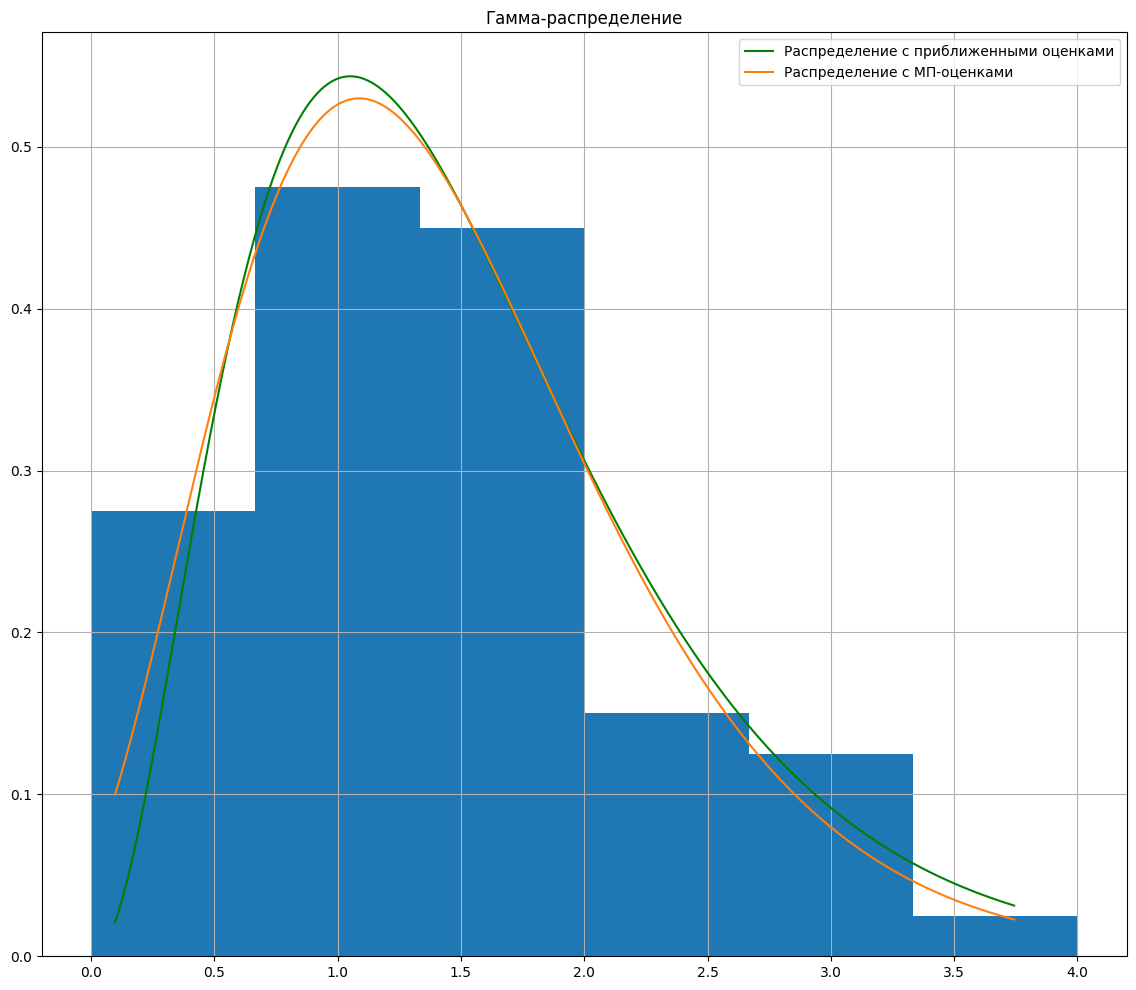

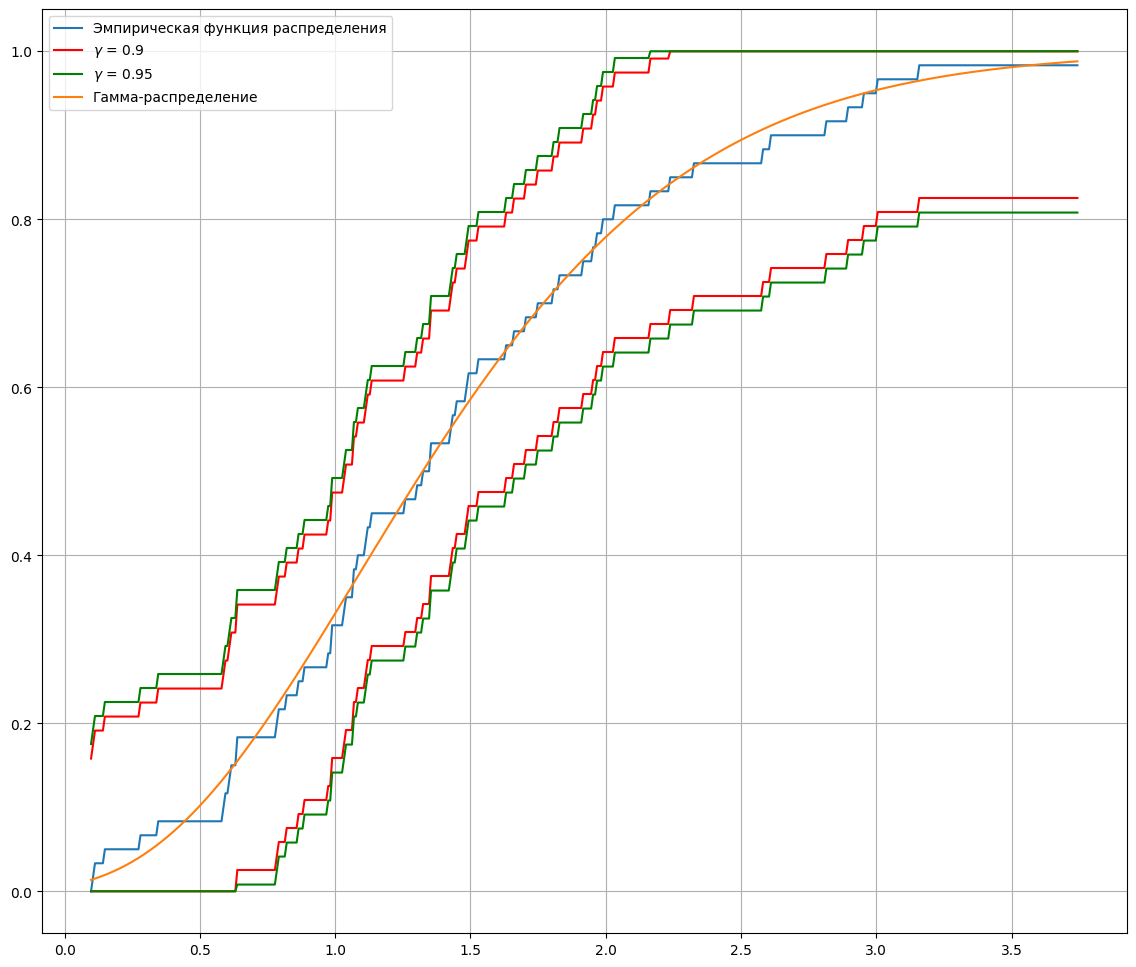

In [9]:
#Гистограмма
# f, ax = plt.subplots(figsize=(14, 12))

# ax.hist(numbers, bins=bins, density=True)
# ax.plot(grid, expon.pdf(grid, scale = mean_theta_exp1[0]), color='g', label='Распределение с приближенными оценками')
# ax.plot(grid, expon.pdf(grid, scale=mean_theta_exp2[1]), label='Распределение с МП-оценками')
# ax.grid()
# ax.legend()
# ax.set_title("Экспоненциальное распределение")

# #График эфр
# fig, ax = plt.subplots(figsize=(14, 12))

# ax.plot(grid, emp_df(grid, numbers), label='Эмпирическая функция распределения')
# for _, vargamma, clr in zip(range(2), [0.90, 0.95], ['r', 'g']):
#     ax.plot(grid, L(vargamma), color=clr, label=r"$\gamma$" + f" = {vargamma}")
#     ax.plot(grid, R(vargamma), color=clr)
# ax.plot(grid, expon.cdf(grid, scale=mean_theta_exp2[1]), label='Экспоненциальное распределение')
# ax.grid()
# ax.legend()

#Гистограмма
f, ax = plt.subplots(figsize=(14, 12))

ax.hist(numbers, bins=bins, density=True)
ax.plot(grid, gamma.pdf(grid, a=mean_theta_gamma1[0], scale = mean_theta_gamma1[1]), color='g', label='Распределение с приближенными оценками')
ax.plot(grid, gamma.pdf(grid, a=mean_theta_gamma2[0],
                        loc = mean_theta_gamma2[1],
                        scale=mean_theta_gamma2[2]), label='Распределение с МП-оценками')
ax.grid()
ax.legend()
ax.set_title("Гамма-распределение")

#График эфр
fig, ax = plt.subplots(figsize=(14, 12))

ax.plot(grid, emp_df(grid, numbers), label='Эмпирическая функция распределения')
for _, vargamma, clr in zip(range(2), [0.90, 0.95], ['r', 'g']):
    ax.plot(grid, L(vargamma), color=clr, label=r"$\gamma$" + f" = {vargamma}")
    ax.plot(grid, R(vargamma), color=clr)
ax.plot(grid, gamma.cdf(grid, a=mean_theta_gamma2[0], loc=mean_theta_gamma2[1], scale=mean_theta_gamma2[2]), label='Гамма-распределение')
ax.grid()
ax.legend()

## Анализ-сравнение полученных результатов

In [ ]:
print("Выборка")
print(f"Выборочное среднее: {round(np.mean(numbers), 5)}")
print(f"Выборочная дисперсия: {round(np.var(numbers, ddof=1), 5)}")
print(f"Коэффициент эксцесса: {round(kurtosis(numbers, bias=False), 5)}")
print(f"Коэффициент асимметрии: {round(skew(numbers, bias=False), 5)}")

# print("\nЭкспоненциальное распределение")
# mean, var, skew, kurt = expon.stats( scale=mean_theta_exp2[1], moments='mvsk')
# print(f"Среднее: {np.round(mean, 5)}")
# print(f"Дисперсия: {np.round(var, 5)}")
# print(f"Коэффициент эксцесса: {np.round(kurt, 5)}")
# print(f"Коэффициент асимметрии: {np.round(skew, 5)}")

print("\nГамма-распределение")
mean, var, skew, kurt = gamma.stats(a=mean_theta_gamma2[0], loc=mean_theta_gamma2[1], scale=mean_theta_gamma2[2],
                                    moments='mvsk')
print(f"Среднее: {np.round(mean, 5)}")
print(f"Дисперсия: {np.round(var, 5)}")
print(f"Коэффициент эксцесса: {np.round(kurt, 5)}")
print(f"Коэффициент асимметрии: {np.round(skew, 5)}")

Выборка
Выборочное среднее: 1.43933
Выборочная дисперсия: 0.66244
Коэффициент эксцесса: 0.15865
Коэффициент асимметрии: 0.67083

Гамма-распределение
Среднее: 1.43934
Дисперсия: 0.66986
Коэффициент эксцесса: 1.11171
Коэффициент асимметрии: 0.8609
